In [1]:
import psycopg2 as ps
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt


con = ps.connect("dbname='seeDB' user='' host='localhost' password=''")
cur = con.cursor()


In [2]:
# KL-Divergence(target, reference)
def kl_divergence(target_val, reference_val):
    tgt = target_val.reshape(-1)
    ref = reference_val.reshape(-1)

    if np.sum(tgt) > 0 and np.sum(ref) > 0:
        tgt_prob = tgt / np.sum(tgt)
        ref_prob = ref / np.sum(ref)

        return -np.sum([qi * np.log(pi/qi) for qi, pi in zip(tgt_prob, ref_prob) if pi > 0 and qi > 0])
    else:
        return -0

In [3]:
def visualize(data_a, data_b, view_tuple, figsize=(10, 6)):
    group_category, measure, operation = view_tuple

    df = pd.DataFrame({'Data A': data_a.values(), 'Data B': data_b.values()}, index=data_a.keys())

    ax = df.plot(kind='bar', figsize=figsize, color=['b', 'g'])
    ax.set_xlabel(group_category)
    ax.set_ylabel('{}({})'.format(operation, measure))
    ax.set_xticklabels(data_a.keys(), rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [4]:
functions = {"count", "sum", "avg", "min", "max"}
attributes = {"workclass", "education", "occupation", "relationship", "race", "sex", "native_country", "economic_indicator"}
measurements = {"age", "fnlwgt", "hours_per_week", "capital_gain", "capital_loss"}

views = {}

count = 0
for attribute in attributes:
    for function in functions:
        for measurement in measurements:
            view = (function, measurement, attribute)
            views[count] = view
            count += 1

print('Total number of views:', len(views))
# print(views)

Total number of views: 200


SELECT native_country, max(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, max(capital_gain) FROM unmarried GROUP BY native_country;


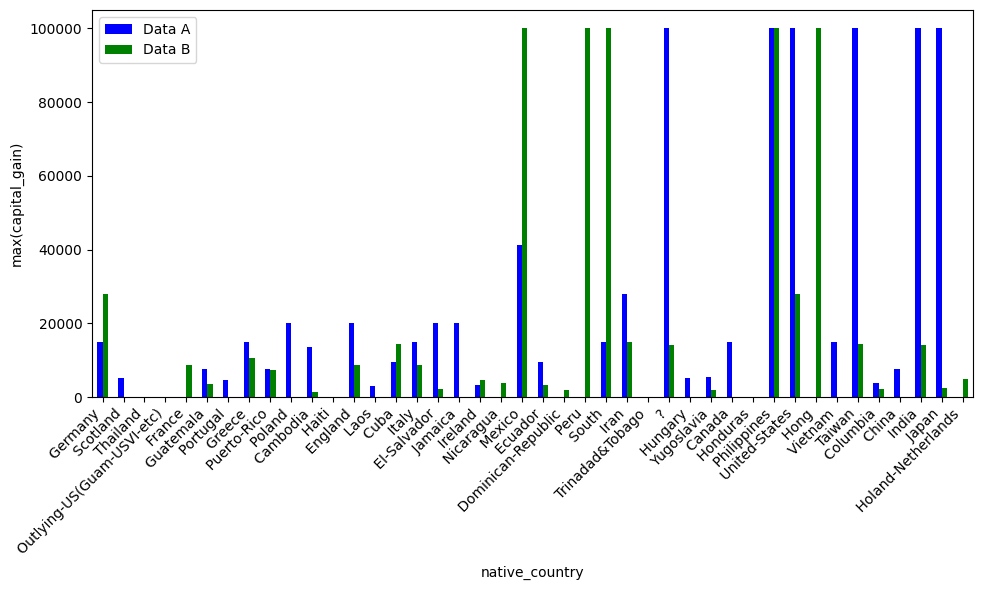

SELECT native_country, avg(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, avg(capital_gain) FROM unmarried GROUP BY native_country;


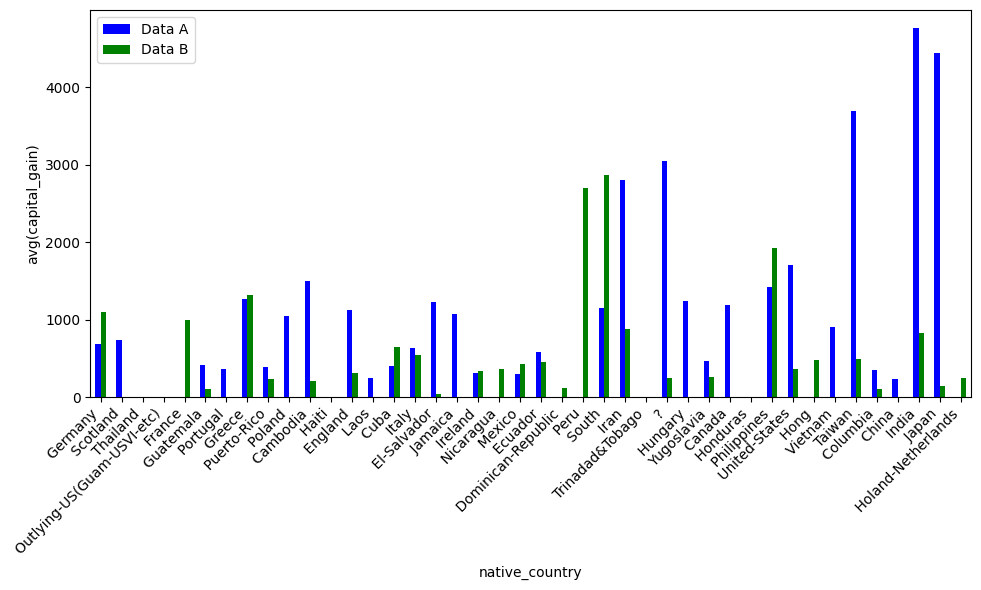

SELECT workclass, min(hours_per_week) FROM married GROUP BY workclass;
SELECT workclass, min(hours_per_week) FROM unmarried GROUP BY workclass;


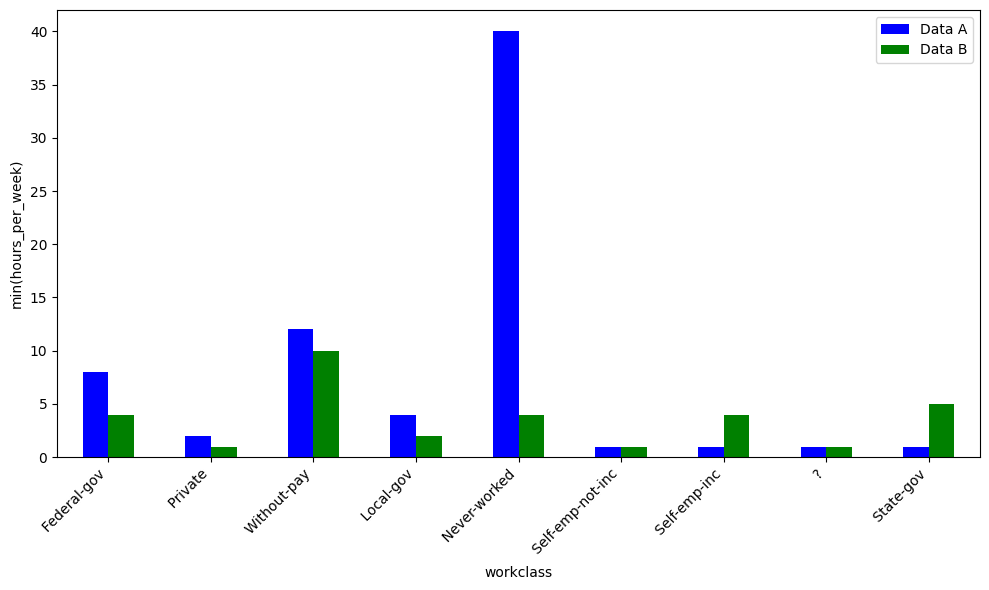

SELECT economic_indicator, sum(capital_loss) FROM married GROUP BY economic_indicator;
SELECT economic_indicator, sum(capital_loss) FROM unmarried GROUP BY economic_indicator;


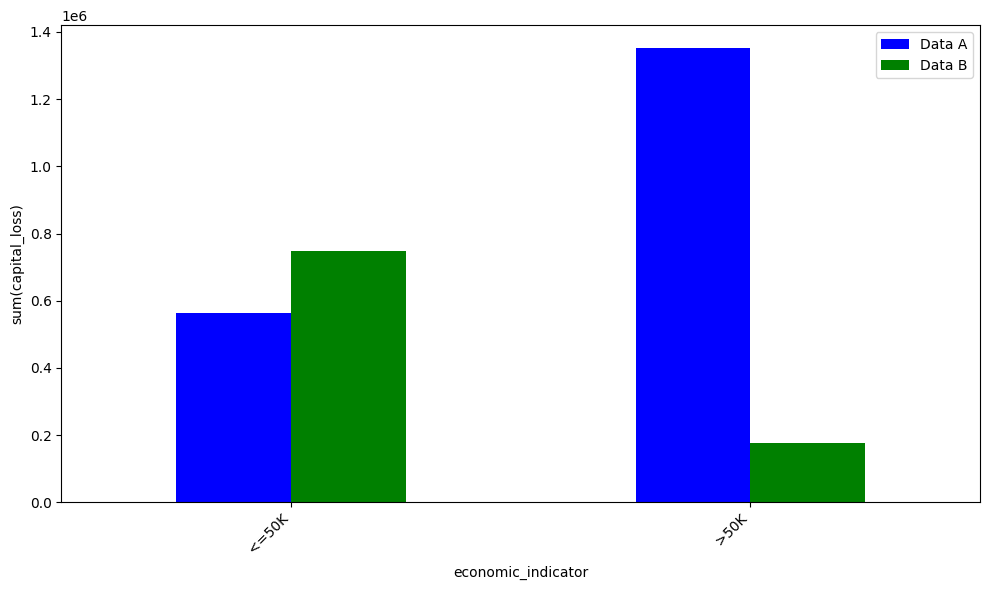

SELECT race, avg(capital_gain) FROM married GROUP BY race;
SELECT race, avg(capital_gain) FROM unmarried GROUP BY race;


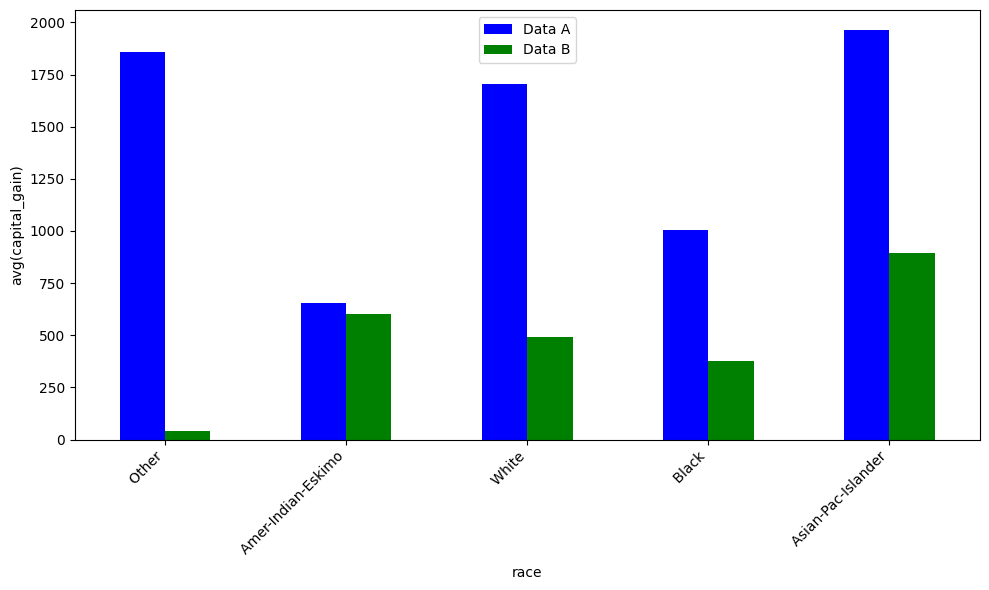

In [7]:
def sharing_based_query(views_data, tables_data):
    select_a_str, select_m_str, group_by_str = [], [], []
    for i, (function, measure, attribute) in views_data.items():
        select_a_str.append(attribute)
        select_m_str.append(f"{function}({measure}) as v{i}")
        group_by_str.append(attribute)

    select_a_str = ', '.join(set(select_a_str))
    select_m_str = ', '.join(select_m_str)
    group_by_str = ', '.join(set(group_by_str))

    data = []
    for table in tables_data:
        query = f"SELECT {select_a_str}, {select_m_str} FROM {table} GROUP BY GROUPING SETS ({group_by_str});"
        cur.execute(query)
        data.append(cur.fetchall())
    cols = [desc[0] for desc in cur.description]
    return data, cols


target_df = pd.DataFrame(data[0], columns=cols)
reference_df = pd.DataFrame(data[1], columns=cols)
view_scores = {}
for view_id, (function, measure, attribute) in views.items():
    target = target_df.loc[target_df[attribute].notnull(), [attribute, f'v{view_id}']]
    reference = reference_df.loc[reference_df[attribute].notnull(), [attribute, f'v{view_id}']]
    tmp_df = target.join(reference.set_index(attribute), on=attribute, how="inner", lsuffix='_tgt', rsuffix='_ref')
    target_values = tmp_df[f'v{view_id}_tgt'].values
    reference_values = tmp_df[f'v{view_id}_ref'].values
    score = kl_divergence(target_values, reference_values)
    view_scores[view_id] = score
views_ranking = sorted(view_scores.items(), key=lambda x: x[1], reverse=True)


def top_k_views(ranking, k):
    for view_id in ranking[:k]:
        function, measure, attribute = views[view_id]

        query = f"SELECT {attribute}, {function}({measure}) FROM married GROUP BY {attribute};"
        print(query)
        cur.execute(query)
        target_rows = cur.fetchall()

        query = f"SELECT {attribute}, {function}({measure}) FROM unmarried GROUP BY {attribute};"
        print(query)
        cur.execute(query)
        reference_rows = cur.fetchall()

        target_dict = dict(target_rows)
        reference_dict = dict(reference_rows)

        for key in set(target_dict.keys()).symmetric_difference(reference_dict.keys()):
            target_dict.setdefault(key, 0)
            reference_dict.setdefault(key, 0)

        visualize(target_dict, reference_dict, (attribute, measure, function))


# Example usage
K = 5
top_k_views([r[0] for r in views_ranking], K)

In [9]:
# Pruning based Optimization - Phase 1
K = 5
n_phases = 10

view_scores = {k: [] for k, v in views.items()}
current_views = {k: v for k, v in views.items()}

delta = 0.05

for i in range(n_phases):
    tables = ['married', 'unmarried']
    data, cols = sharing_based_query(views, tables)
    
    tgt_df = pd.DataFrame(data[0], columns=cols)
    ref_df = pd.DataFrame(data[1], columns=cols)
    
    for vid, (f, m, a) in current_views.items():
        tgt = tgt_df.loc[tgt_df[a].notnull(), [a, 'v{}'.format(vid)]]
        ref = ref_df.loc[ref_df[a].notnull(), [a, 'v{}'.format(vid)]]
        tmp = tgt.join(ref.set_index(a), on=a, how="inner", lsuffix='_tgt', rsuffix='_ref')

        tgt_val = tmp['v{}_tgt'.format(vid)].values
        ref_val = tmp['v{}_ref'.format(vid)].values
        score = kl_divergence(tgt_val, ref_val)
        view_scores[vid].append(score)

Total number of pruned views: 1.
SELECT native_country, max(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, max(capital_gain) FROM unmarried GROUP BY native_country;


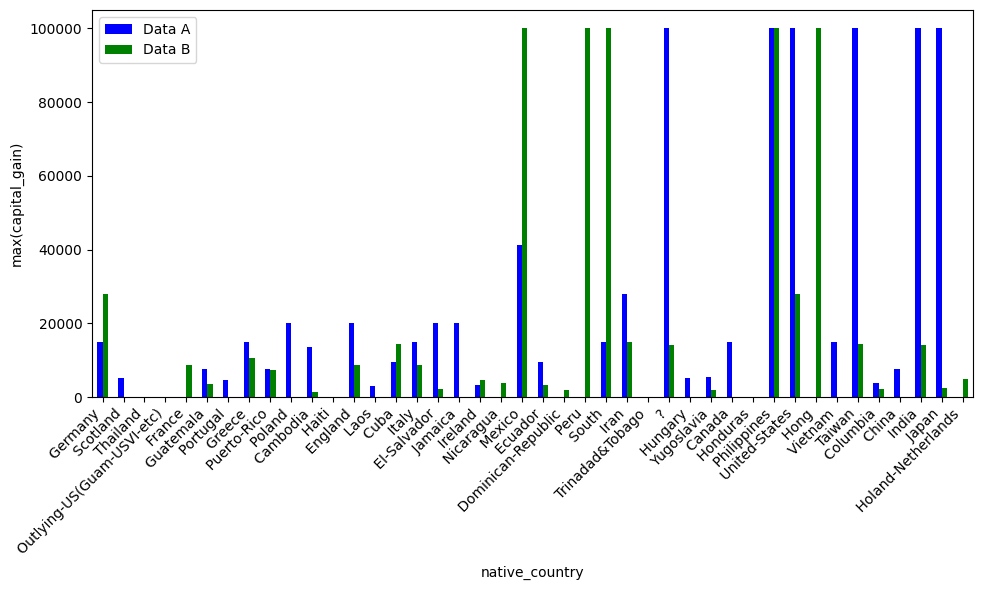

SELECT native_country, avg(capital_gain) FROM married GROUP BY native_country;
SELECT native_country, avg(capital_gain) FROM unmarried GROUP BY native_country;


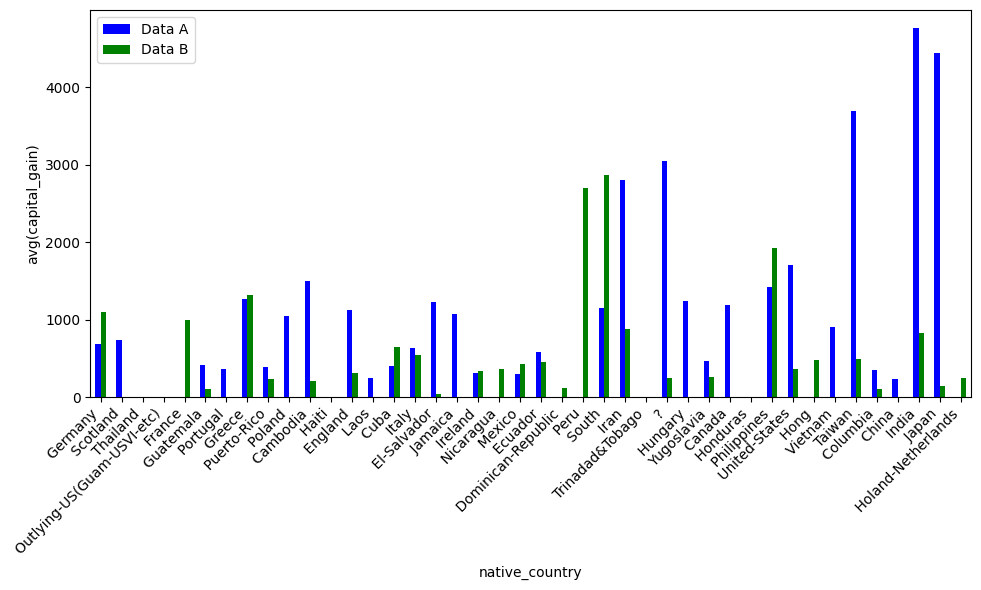

SELECT workclass, min(hours_per_week) FROM married GROUP BY workclass;
SELECT workclass, min(hours_per_week) FROM unmarried GROUP BY workclass;


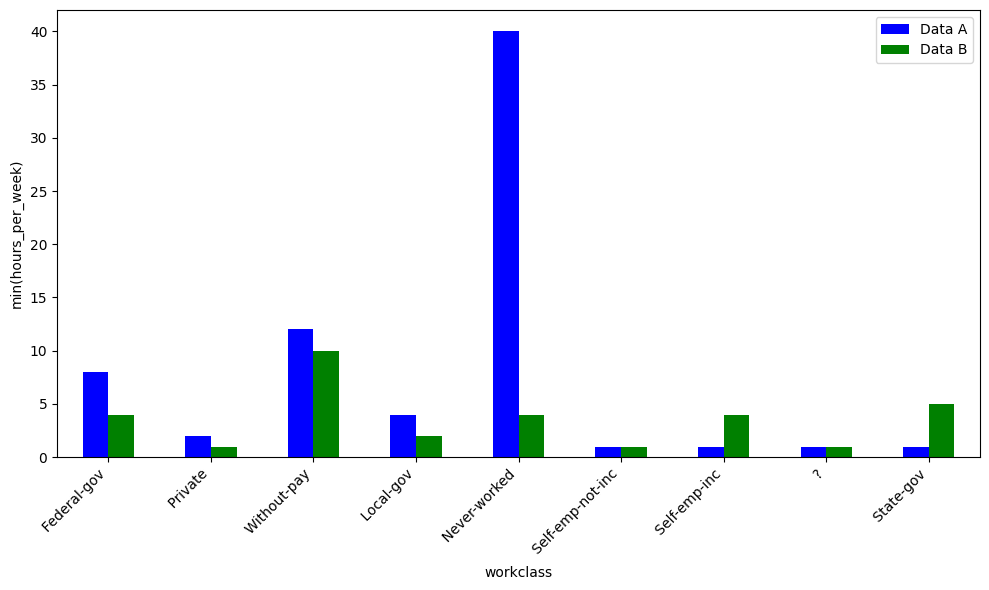

SELECT economic_indicator, sum(capital_loss) FROM married GROUP BY economic_indicator;
SELECT economic_indicator, sum(capital_loss) FROM unmarried GROUP BY economic_indicator;


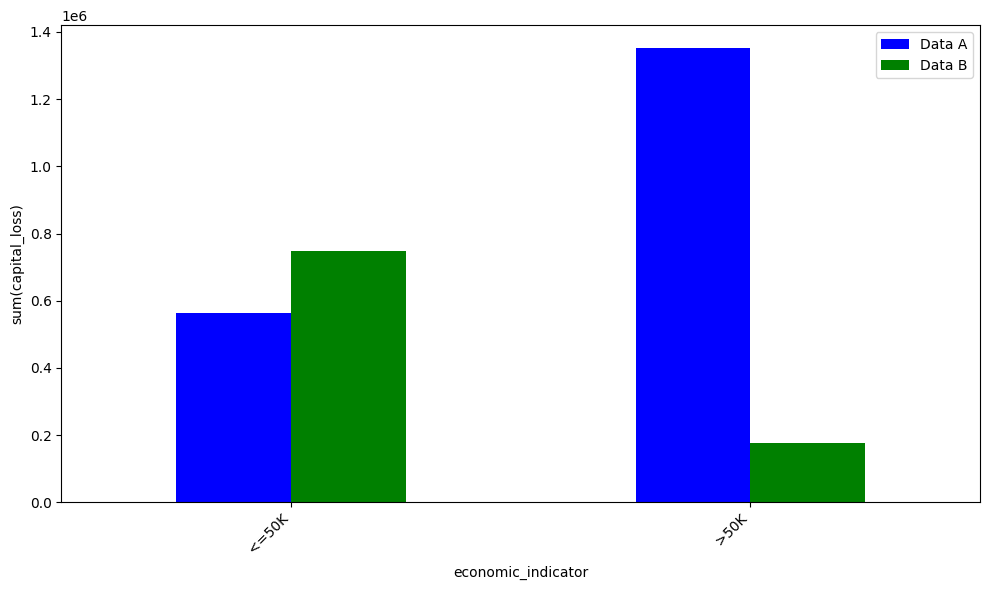

SELECT race, avg(capital_gain) FROM married GROUP BY race;
SELECT race, avg(capital_gain) FROM unmarried GROUP BY race;


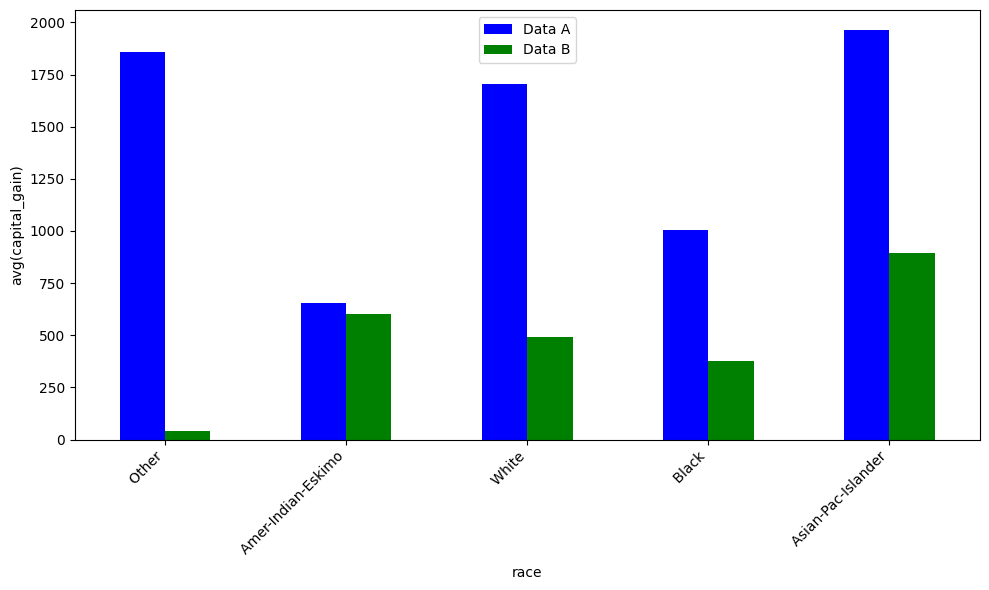

In [10]:
# Pruning based Optimization top k views
m, N = n_phases, n_phases
eps = np.sqrt((0.5/m)*(1-((m-1)/N))*(2*np.log(np.log(m))+np.log((np.pi**2)/(3*delta))))

current_view_scores = [(k, v) for k, v in view_scores.items() if k in current_views]
views_ranking = sorted(current_view_scores, key=lambda x: np.mean(x[1]), reverse=True)
top_k_smallest_lower_bound = np.mean(views_ranking[K][1]) - eps

# Perform pruning
pruned_views = []
for k, v in view_scores.items():
    if k in current_views and np.mean(v) + eps < top_k_smallest_lower_bound:
        del current_views[k]
        pruned_views.append(k)
        # Stop pruning once one unnecessary view is pruned
        break
        
print('Total number of pruned views: {}.'.format(len(pruned_views)))
top_k_views([r[0] for r in views_ranking], K)